In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="aabec94166c9443a9d1112012d2f1e6f",
                                                           client_secret="a1bcca484f9d4a4a9b80354c0c78e00a"))

In [2]:
def json_extract(obj, key):
    """Recursively fetch values from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == key:
                    arr.append(v)
                elif isinstance(v, (dict, list)):
                    extract(v, arr, key)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    values = extract(obj, arr, key)
    return values

In [3]:
# Helper functions to reduce code
def get_uri_df(playlist, offset, fields=['items.track.uri']):
    return pd.Series(json_extract(sp.playlist_tracks(playlist, fields=fields, offset=offset), 'uri'))
    
def clean_uris(uris):
    return uris[uris.str.contains('spotify:track:*')]

def get_feat_df(tracks, offset):
    data_batch = sp.audio_features(tracks=tracks[offset:offset+100])
    # return pd.DataFrame(data_batch).drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'key', 'duration_ms', 'time_signature'])
    return pd.DataFrame(data_batch)

def get_X_pca(pipeline, features_dict, genre):
    '''Helper function to transform X'''
    X = features_dict[genre].to_numpy()
    X_tr = pipeline['scaler'].transform(X)
    return pipeline['pca'].transform(X_tr)

In [4]:
PLAYLIST_10K  = 'spotify:playlist:1G8IpkZKobrIlXcVPoSIuf?si=995e484d55d74f94'    # Top 10,000 playlist

uri_all = []
for i in range(0, 9900, 100):
    uri_batch = get_uri_df(PLAYLIST_10K, offset=i)
    uri_all.append(uri_batch)

In [5]:
tracks = pd.concat(uri_all).reset_index(drop=True).dropna()
tracks = tracks[tracks.str.contains('spotify:track:*')]

In [6]:
track_features_all = []
for i in range(0, 9900, 100):
    data_batch = sp.audio_features(tracks=tracks[i:i+100])
    df_track_features_batch = pd.DataFrame(data_batch).drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'key', 'duration_ms', 'time_signature'])
    track_features_all.append(df_track_features_batch)

In [7]:
# Finalized, cleaned data for 10K songs
audio_features = pd.concat(track_features_all).reset_index(drop=True)
audio_features.tail(10)

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
9837,0.737,0.5580,-9.814,1,0.3260,0.394000,0.021000,0.1110,0.525,98.546
9838,0.389,0.7360,-5.945,0,0.0356,0.000004,0.443000,0.2950,0.224,74.992
9839,0.787,0.9400,-9.707,1,0.1880,0.434000,0.000000,0.1510,0.705,106.892
9840,0.243,0.0969,-16.510,1,0.0408,0.971000,0.013700,0.2060,0.385,47.692
9841,0.675,0.3660,-11.566,1,0.0310,0.724000,0.002330,0.1860,0.791,119.122
9842,0.457,0.4800,-15.776,1,0.0300,0.380000,0.016000,0.1420,0.683,157.967
9843,0.389,0.5320,-5.632,1,0.0266,0.001580,0.000532,0.3270,0.212,169.918
9844,0.724,0.4840,-5.986,1,0.0482,0.720000,0.000136,0.0808,0.933,77.124
9845,0.379,0.5410,-8.121,1,0.0304,0.043800,0.015800,0.3380,0.429,91.434
9846,0.679,0.7090,-5.851,0,0.1330,0.676000,0.000000,0.2920,0.673,84.543


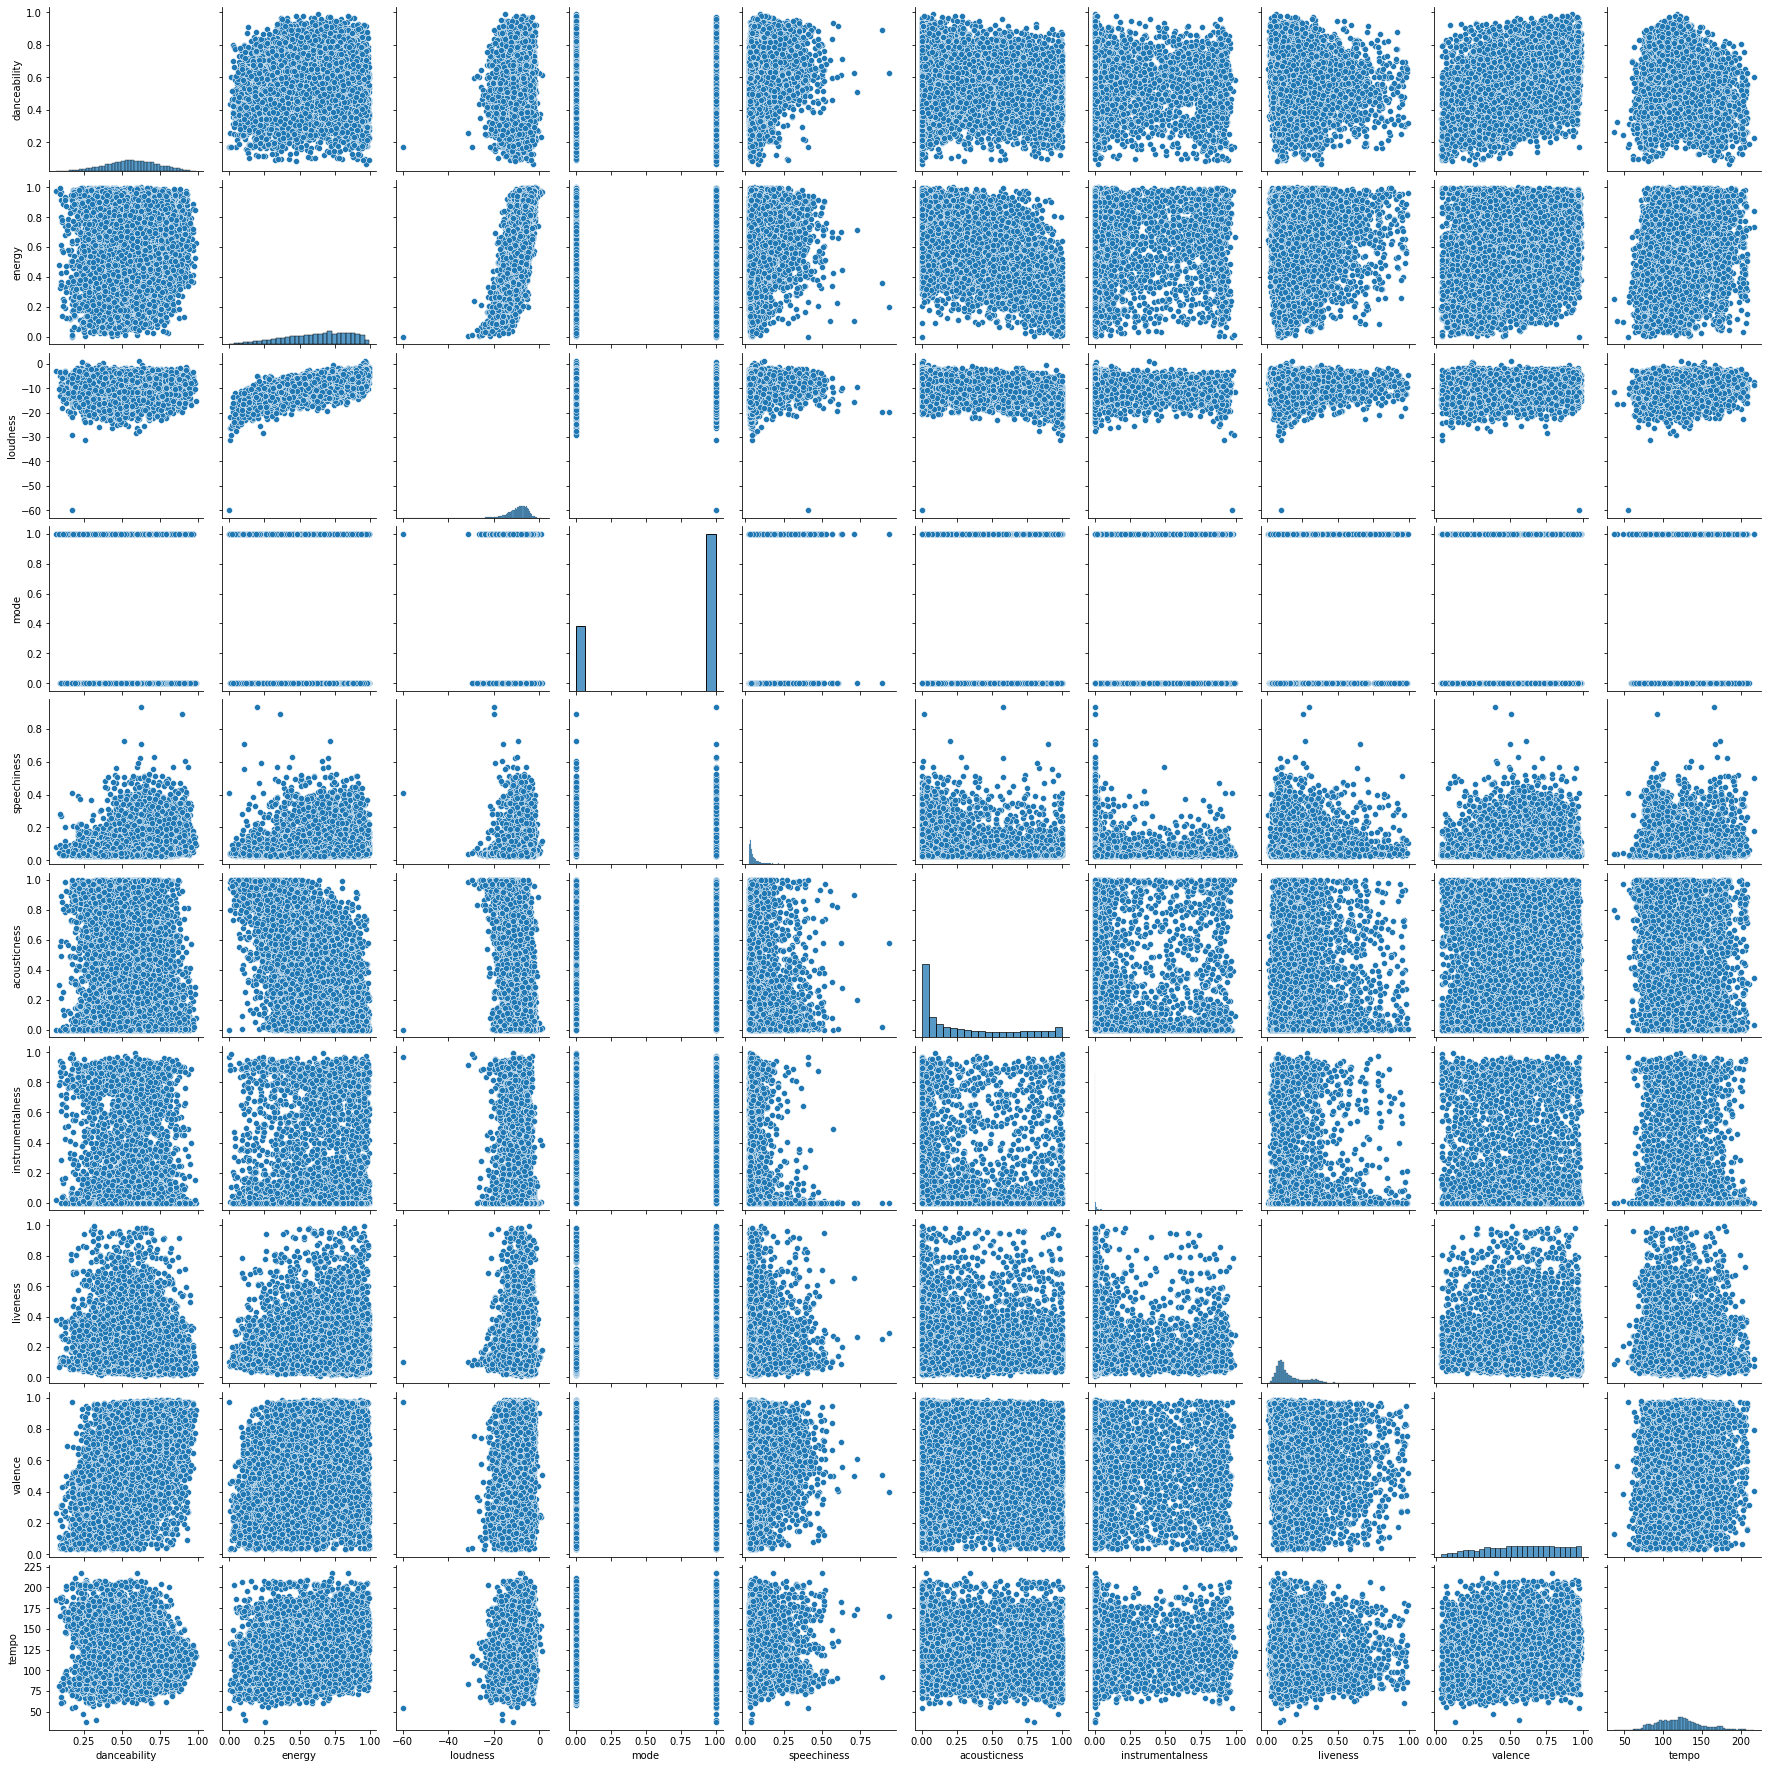

In [8]:
# Column to column pairplot for 10K tracks
sns.pairplot(audio_features)

In [9]:
# Pipeline where X goes through normalization, PCA, and K-means
X = audio_features.to_numpy()
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',    PCA(n_components=2)),
                 ('kmeans', KMeans()),
                 ('MoG', GaussianMixture())])

pipe.fit(X)            

# Transform data of 10K songs
X_tr = pipe['scaler'].transform(X)
X_pca = pipe['pca'].transform(X_tr)

In [10]:
# Setup GridSearch for K-means
parameters = {
    'n_clusters': [2,3,4,5,6]
}

clf = GridSearchCV(pipe['kmeans'], parameters)
clf.fit(X_pca)

GridSearchCV(estimator=KMeans(), param_grid={'n_clusters': [2, 3, 4, 5, 6]})

In [11]:
# Best estimator parameter based on Grid Search
clf.best_params_

{'n_clusters': 6}

In [12]:
### Let's see if we can map different playlists onto the 10K track feature space.
PLAYLIST_HAP  = 'spotify:playlist:0Ol0JfQ13pcEorOe5Lw3E2?si=c495d31df68d4f8f' # uri for happy songs (n>200)
PLAYLIST_SAD  = 'spotify:playlist:5QT5vrIiSFigBWnzHmWzzW?si=d3df3c6b31204e0e' # uri for sad songs   (n>200)
PLAYLIST_LOFI = 'spotify:playlist:5ZSy5LuSo6UA5v8hrGZtk0?si=04615d4cd8b74a02' # uri for lofi        (n<100)
PLAYLIST_DUB  = 'spotify:playlist:3ObJ6Qra3CkV0gNCRTtK0c?si=29bb32bd4a1c4ddb' # uri for dubstep     (n<100)
PLAYLIST_JAZ  = 'spotify:playlist:37i9dQZF1DWV7EzJMK2FUI?si=54fba0a93d1b4b5a' # uri for jazz        (n<400)
PLAYLIST_METAL = 'spotify:playlist:2iFHzm6F41h57HLSpqubyX?si=a7437b8f500c4ce3'# uri for metal       (n>400)

# Organize data cleaning of playlists
uri_dict = {}
uri_dict['pl_hap']  = [get_uri_df(PLAYLIST_HAP, offset=i) for i in range(0, 300, 100)]
uri_dict['pl_sad']  = [get_uri_df(PLAYLIST_SAD, offset=i) for i in range(0, 300, 100)]
uri_dict['pl_lofi'] = [get_uri_df(PLAYLIST_LOFI, offset=i) for i in range(0, 200, 100)]
uri_dict['pl_dub']  = [get_uri_df(PLAYLIST_DUB, offset=i) for i in range(0, 200, 100)]
uri_dict['pl_jaz']  = [get_uri_df(PLAYLIST_JAZ, offset=i) for i in range(0, 400, 100)]
uri_dict['pl_metal']  = [get_uri_df(PLAYLIST_METAL, offset=i) for i in range(0, 400, 100)]

uri_dict['pl_hap']  = pd.concat(uri_dict['pl_hap']).reset_index(drop=True).dropna()
uri_dict['pl_sad']  = pd.concat(uri_dict['pl_sad']).reset_index(drop=True).dropna()
uri_dict['pl_lofi'] = pd.concat(uri_dict['pl_lofi']).reset_index(drop=True).dropna()
uri_dict['pl_dub']  = pd.concat(uri_dict['pl_dub']).reset_index(drop=True).dropna()
uri_dict['pl_jaz']  = pd.concat(uri_dict['pl_jaz']).reset_index(drop=True).dropna()
uri_dict['pl_metal']  = pd.concat(uri_dict['pl_metal']).reset_index(drop=True).dropna()

uri_dict['pl_hap']  = clean_uris(uri_dict['pl_hap'])
uri_dict['pl_sad']  = clean_uris(uri_dict['pl_sad'])
uri_dict['pl_lofi'] = clean_uris(uri_dict['pl_lofi'])
uri_dict['pl_dub']  = clean_uris(uri_dict['pl_dub'])
uri_dict['pl_jaz']  = clean_uris(uri_dict['pl_jaz'])
uri_dict['pl_metal']  = clean_uris(uri_dict['pl_metal'])

# Apologize for atrocious code--became too lazy to write more helper functions for this last part
features_dict = {}
features_dict['feat_hap']  = pd.concat([get_feat_df(uri_dict['pl_hap'], offset=i) for i in range(0, 300, 100)]).reset_index(drop=True).drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'key', 'duration_ms', 'time_signature', 0]).dropna()
features_dict['feat_sad']  = pd.concat([get_feat_df(uri_dict['pl_sad'], offset=i) for i in range(0, 300, 100)]).reset_index(drop=True).drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'key', 'duration_ms', 'time_signature']).dropna()
features_dict['feat_lofi'] = pd.concat([get_feat_df(uri_dict['pl_lofi'], offset=i) for i in range(0, 200, 100)]).reset_index(drop=True).drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'key', 'duration_ms', 'time_signature']).dropna()
features_dict['feat_dub']  = pd.concat([get_feat_df(uri_dict['pl_dub'], offset=i) for i in range(0, 200, 100)]).reset_index(drop=True).drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'key', 'duration_ms', 'time_signature']).dropna()
features_dict['feat_jaz']  = pd.concat([get_feat_df(uri_dict['pl_jaz'], offset=i) for i in range(0, 400, 100)]).reset_index(drop=True).drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'key', 'duration_ms', 'time_signature']).dropna()
features_dict['feat_metal']  = pd.concat([get_feat_df(uri_dict['pl_metal'], offset=i) for i in range(0, 400, 100)]).reset_index(drop=True).drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'key', 'duration_ms', 'time_signature']).dropna()


/tmp/ipykernel_6842/4137404477.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(json_extract(sp.playlist_tracks(playlist, fields=fields, offset=offset), 'uri'))


In [13]:
# Tranform the audio features for each playlist through normalization and PCA
X_hap_pca = get_X_pca(pipe, features_dict, 'feat_hap')
X_sad_pca = get_X_pca(pipe, features_dict, 'feat_sad')
X_lofi_pca = get_X_pca(pipe, features_dict, 'feat_lofi')
X_dub_pca = get_X_pca(pipe, features_dict, 'feat_dub')
X_jaz_pca = get_X_pca(pipe, features_dict, 'feat_jaz')
X_metal_pca = get_X_pca(pipe, features_dict, 'feat_metal')

/tmp/ipykernel_6842/1389594403.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_hap_pca[:, 0], X_hap_pca[:, 1], "k.", color='red', markersize=20)
/tmp/ipykernel_6842/1389594403.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_sad_pca[:, 0], X_sad_pca[:, 1], "k.", color='blue', markersize=20)
/tmp/ipykernel_6842/1389594403.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_lofi_pca[:, 0], X_lofi_pca[:, 1], "k.", color='green', markersize=20)
/tmp/ipykernel_6842/1389594403.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument 

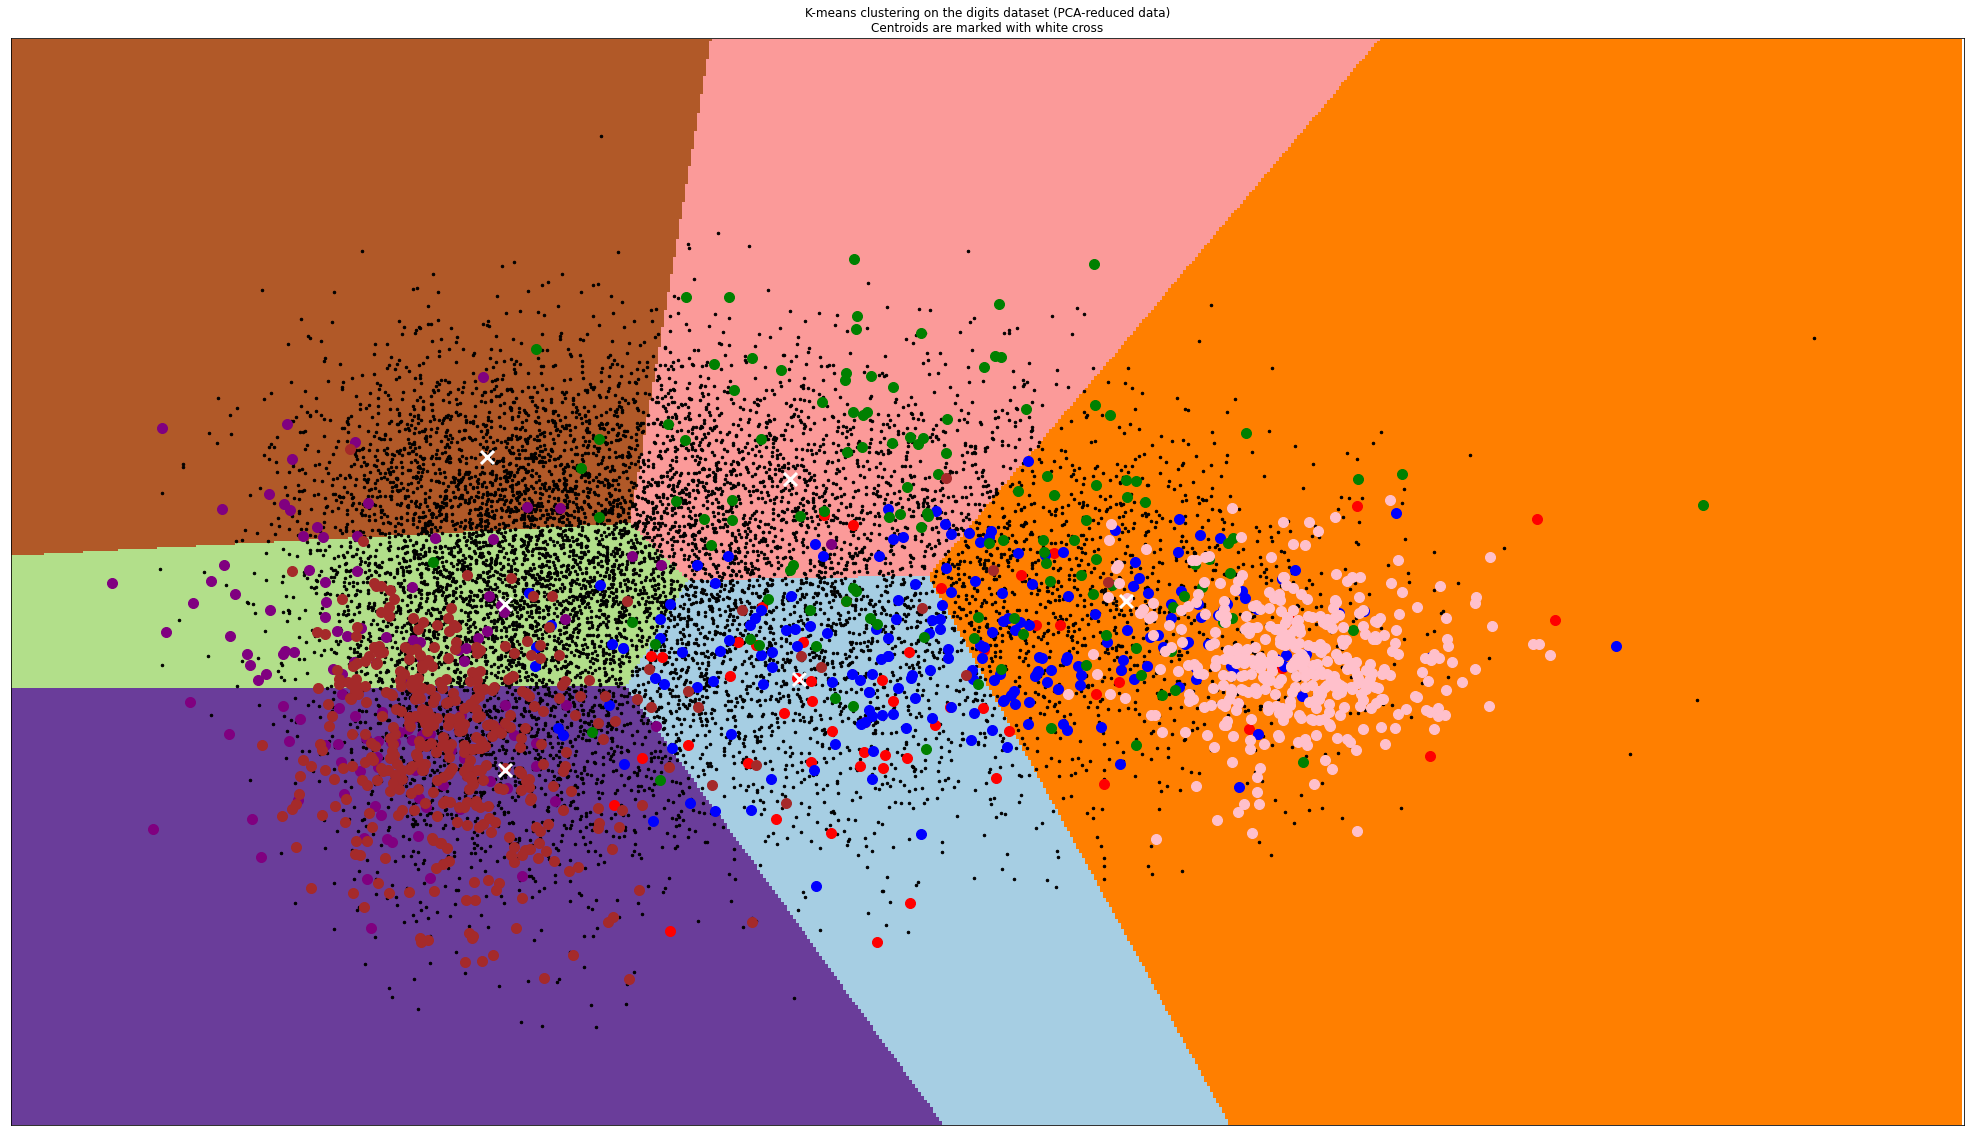

In [14]:
import matplotlib.pyplot as plt

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = clf.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(35,20))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(X_pca[:, 0], X_pca[:, 1], "k.", markersize=5)
plt.plot(X_hap_pca[:, 0], X_hap_pca[:, 1], "k.", color='red', markersize=20)
plt.plot(X_sad_pca[:, 0], X_sad_pca[:, 1], "k.", color='blue', markersize=20)
plt.plot(X_lofi_pca[:, 0], X_lofi_pca[:, 1], "k.", color='green', markersize=20)
plt.plot(X_dub_pca[:, 0], X_dub_pca[:, 1], "k.", color='purple', markersize=20)
plt.plot(X_jaz_pca[:, 0], X_jaz_pca[:, 1], "k.", color='pink', markersize=20)
plt.plot(X_metal_pca[:, 0], X_metal_pca[:, 1], "k.", color='brown', markersize=20)
# Plot the centroids as a white X
centroids = clf.best_estimator_.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [15]:
parameters_mog = {
    'n_components' : [2, 3, 4, 5, 6, 7, 8]
}

clf_mog = GridSearchCV(pipe['MoG'], parameters_mog)
clf_mog.fit(X_pca)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'n_components': [2, 3, 4, 5, 6, 7, 8]})

In [16]:
clf_mog.best_params_

{'n_components': 5}

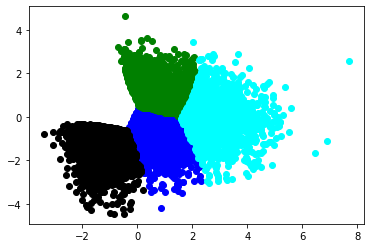

In [17]:
#predictions from gmm
labels = clf_mog.predict(X_pca)
frame = pd.DataFrame(X_pca)
frame['cluster'] = labels
frame.columns = ['X', 'Y', 'cluster']

color=['blue','green','cyan', 'black']
for k in range(0,4):
    X_pca = frame[frame["cluster"]==k]
    plt.scatter(X_pca["X"],X_pca["Y"],c=color[k])
plt.show()